In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV

In [49]:
dataGreaterthan2003 = pd.read_csv('dataGreaterthan2003_20230313.csv')
dataGreaterthan2003['Unnamed: 0'] = pd.to_datetime(dataGreaterthan2003['Unnamed: 0'])
dataGreaterthan2003.set_index('Unnamed: 0', inplace=True)

In [50]:
dataGreaterthan2003

,Official Core Consumer Price Index,Energy Price Index,Food Price Index,Headline Consumer Price Index,Producer Price Index,Petrol,Diesel
Unnamed: 0,,,,,,,
2003-01-01,0.107892,-0.290909,0.074376,0.144494,0.022761,-1.279750,-1.325488
2003-02-01,0.111888,-0.254545,0.084564,0.148480,0.031588,-1.265934,-1.312639
2003-03-01,0.115884,-0.254545,0.090678,0.154459,0.035223,-1.265934,-1.312639
2003-04-01,0.121878,-0.272727,0.094753,0.162431,0.022761,-1.317835,-1.360432
2003-05-01,0.123876,-0.309091,0.102904,0.162431,0.017395,-1.315012,-1.351306
...,...,...,...,...,...,...,...
2022-08-01,0.879121,1.018182,1.087112,1.059292,1.310688,1.272001,1.467847
2022-09-01,0.891109,1.054545,1.113602,1.069258,1.337170,1.058409,1.348984
2022-10-01,0.905095,1.200000,1.162506,1.109118,1.337170,0.978122,1.317154


## Univariate Forecasting

### train and test split

In [51]:
test_size = 12

#test sets
lstmTestDF = dataGreaterthan2003.tail(12)

# train sets
# get the number of rows in the dataframe
num_rows = dataGreaterthan2003.shape[0]

# get all rows except the last 12 rows
lstmTrainDF = dataGreaterthan2003.iloc[:num_rows-12, :]

In [52]:
def segregate_train_test_data(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

### model definition

In [53]:
# Define a function to create the model
def create_lstm_model_hyperparameters(col, learning_rate, epochs):
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train_dict[col].shape[1], X_train_dict[col].shape[2])))
    model.add(Dense(1))
    optimizer = Adam(lr=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    model.fit(X_train_dict[col], y_train_dict[col], epochs=epochs, batch_size=64, validation_data=(X_test_dict[col], y_test_dict[col]))
    test_loss  = model.evaluate(X_test_dict[col], y_test_dict[col])
    return test_loss

### reshape input data

In [54]:
X_train_dict = {}
y_train_dict = {}
X_test_dict = {}
y_test_dict = {}
window = 3
for col in lstmTrainDF.columns:
    X_train_dict[col], y_train_dict[col] = segregate_train_test_data(data=lstmTrainDF[col], window_size=window)
    X_test_dict[col], y_test_dict[col] = segregate_train_test_data(data=lstmTestDF[col], window_size=window)
    X_train_dict[col] = np.reshape(X_train_dict[col], (X_train_dict[col].shape[0], X_train_dict[col].shape[1], 1))
    X_test_dict[col] = np.reshape(X_test_dict[col], (X_test_dict[col].shape[0], X_test_dict[col].shape[1], 1))

### hyperparameter tuning

In [8]:
# Define a list of hyperparameters to tune

epochs = [50, 100, 150]
learning_rate = [0.001, 0.01, 0.1]

# Perform grid search for hyperparameter tuning
results = []

for col in lstmTrainDF.columns:
    for lr in learning_rate:
        for epoch in epochs:
            loss = create_lstm_model_hyperparameters(col, lr, epoch)
            results.append({'index': col, 'learning_rate': lr,'epochs': epoch, 'loss': loss})

# Convert results to a DataFrame
results = pd.DataFrame(results)

Epoch 54/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0063 - val_loss: 0.0338
Epoch 55/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0065 - val_loss: 0.0329
Epoch 56/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0063 - val_loss: 0.0280
Epoch 57/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0062 - val_loss: 0.0512
Epoch 58/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0064 - val_loss: 0.0305
Epoch 59/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0072 - val_loss: 0.0423
Epoch 60/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0068 - val_loss: 0.0289
Epoch 61/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0075 - val_loss: 0.0290
Epoch 62/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0067 - val_loss: 0.0484
Epoch 63/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0065 - val_loss: 0.0289
Epoch 64/100
4/4 

In [9]:
# Group by 'group' column and find minimum value of 'value' column
min_values = results.groupby('index')['loss'].min()

# Filter original dataframe to only retain rows with minimum value for each group
result = results[results['loss'].isin(min_values)]

# Output result
result.set_index('index', inplace=True)

result

,learning_rate,epochs,loss
index,,,
Official Core Consumer Price Index,0.010,50,0.000113
Energy Price Index,0.001,150,0.092650
Food Price Index,0.001,100,0.001342
Headline Consumer Price Index,0.001,100,0.000480
Producer Price Index,0.010,150,0.003025
Petrol,0.010,50,0.043778
Diesel,0.010,50,0.033809


In [55]:
# result.to_csv('lstmHyperParameters.csv', index = True)
result = pd.read_csv('lstmHyperParameters.csv').set_index('index')

In [56]:
result_dict = result.to_dict(orient='index')

In [57]:
X_dict = {}
y_dict = {}

for col in lstmTrainDF.columns:
    X_dict[col], y_dict[col] = segregate_train_test_data(data=lstmTrainDF[col], window_size=3)
    X_dict[col] = np.reshape(X_dict[col], (X_dict[col].shape[0], X_dict[col].shape[1], 1))   

### model implementation

In [58]:
# Define a function to create the model
def create_lstm_model_implementation(col, learning_rate, epochs):
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train_dict[col].shape[1], X_train_dict[col].shape[2])))
    model.add(Dense(1))
    optimizer = Adam(lr=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    model.fit(X_train_dict[col], y_train_dict[col], epochs=epochs, batch_size=64, validation_data=(X_test_dict[col], y_test_dict[col]))
    return model

In [59]:
result = {}
lstm_aic_dict = {}
lstm_bic_dict = {}

for col in lstmTrainDF.columns:
    learning_rate = result_dict[col]['learning_rate']
    epochs = result_dict[col]['epochs']
    model = create_lstm_model_implementation(col= col,learning_rate=learning_rate,epochs=epochs)
    predictions = model.predict(X_test_dict[col])
    result[col] = predictions.reshape(-1)

    lstm_residuals = y_test_dict[col][:9] - result[col]
    lstm_model_params = model.count_params()
    lstm_model_loglik = -0.5 * len(lstm_residuals) * np.log(np.mean(np.square(lstm_residuals))) - 0.5 * lstm_model_params
    lstm_aic_dict[col] = -2 * lstm_model_loglik + 2 * lstm_model_params

    lstm_mse = mean_squared_error(y_test_dict[col][:9], result[col])
    lstm_bic_dict[col] = np.log(len(y_test_dict[col][:9])) * len(model.trainable_weights) - 2 * np.log(lstm_mse)


4/4 [==============================] - 0s 8ms/step - loss: 0.0046 - val_loss: 0.1780
Epoch 10/50
4/4 [==============================] - 0s 12ms/step - loss: 0.0043 - val_loss: 0.1488
Epoch 11/50
4/4 [==============================] - 0s 17ms/step - loss: 0.0039 - val_loss: 0.1217
Epoch 12/50
4/4 [==============================] - 0s 12ms/step - loss: 0.0039 - val_loss: 0.0977
Epoch 13/50
4/4 [==============================] - 0s 7ms/step - loss: 0.0038 - val_loss: 0.1045
Epoch 14/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0036 - val_loss: 0.1167
Epoch 15/50
4/4 [==============================] - 0s 8ms/step - loss: 0.0035 - val_loss: 0.1260
Epoch 16/50
4/4 [==============================] - 0s 21ms/step - loss: 0.0033 - val_loss: 0.1312
Epoch 17/50
4/4 [==============================] - 0s 8ms/step - loss: 0.0033 - val_loss: 0.1063
Epoch 18/50
4/4 [==============================] - 0s 17ms/step - loss: 0.0031 - val_loss: 0.0933
Epoch 19/50
4/4 [===================

In [60]:
lstmResultDFIndex = lstmTestDF.index[:(lstmTestDF.shape[0] - window)]
lstmResultDF = pd.DataFrame(result, index = lstmResultDFIndex)
lstmTrainDF.columns = [col + ' Train' for col in lstmTrainDF.columns]
lstmTestDF.columns = [col + ' Test' for col in lstmTestDF.columns]
lstmResultDF.columns = [col + ' Prediction' for col in lstmResultDF.columns]

### calculating metrics

In [61]:
# Calculate MSE

# create an empty dataframe to store the MSE results
lstm_mse_dict = {}
lstm_mae_dict = {}

# loop through each column in dataframe
for col in dataGreaterthan2003.columns:
    # calculate the MSE for the current column using NumPy's `mean` and `square` functions
    mse = np.mean(np.square(lstmTestDF[f"{col} Test"].head(9) - lstmResultDF[f"{col} Prediction"]))
    mae = mean_absolute_error(lstmTestDF[f"{col} Test"].head(9), lstmResultDF[f"{col} Prediction"])
    # add the MSE result for the current column to the `mse_df` dataframe
    lstm_mse_dict[col] = mse
    lstm_mae_dict[col] = mae

In [62]:
# Combine the dictionaries into a list
lstm_metrics_dict_list = [lstm_mse_dict, lstm_mae_dict, lstm_aic_dict, lstm_bic_dict]

# Convert the list of dictionaries to a dataframe
metricsDf = pd.DataFrame(lstm_metrics_dict_list, index=[lstm_mse_dict, lstm_mae_dict, lstm_aic_dict, lstm_bic_dict])

# Transpose the dataframe to have the keys as index
metricsDf = metricsDf.T

# Rename the columns
metricsDf.columns = ['mse', 'mae', 'aic', 'bic']

metricsDf.to_csv('metrics_lstm.csv', index = True)

metricsDf

,mse,mae,aic,bic
Official Core Consumer Price Index,0.002309,0.047818,50809.061241,27.416958
Energy Price Index,0.057820,0.209116,50859.163922,16.283029
Food Price Index,0.005515,0.070768,50822.327247,24.468957
Headline Consumer Price Index,0.004212,0.064096,50814.859816,26.128386
Producer Price Index,0.013291,0.114225,50836.309395,21.361813
Petrol,0.048343,0.162542,50856.380145,16.901646
Diesel,0.053394,0.188417,50852.456578,17.773550


### Evaluating model

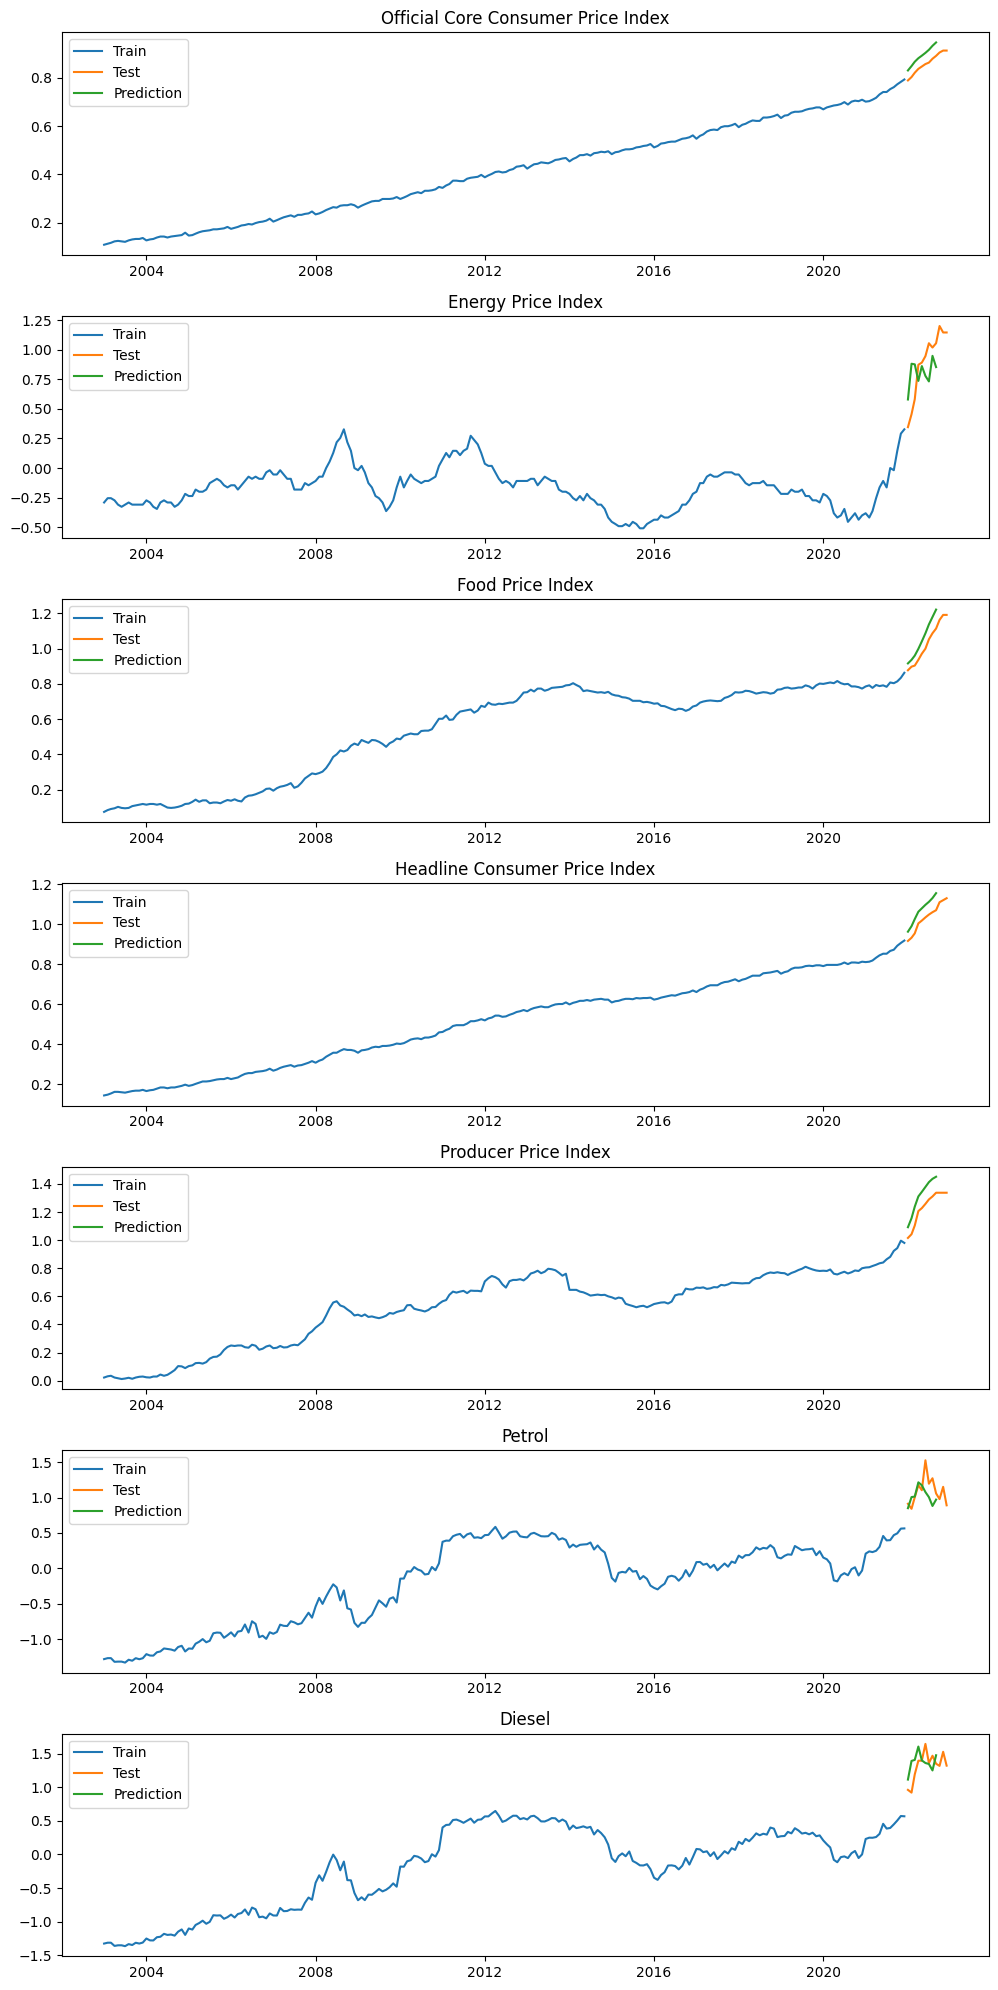

In [63]:
# merge the three dataframes on the index
merged_df = pd.concat([lstmTrainDF, lstmTestDF,lstmResultDF],axis=1)
merged_df
# plot the train, test, and prediction values


fig,axes = plt.subplots(7,1,figsize=(10,20),)

for i,col in enumerate(['Official Core Consumer Price Index','Energy Price Index','Food Price Index','Headline Consumer Price Index','Producer Price Index','Petrol','Diesel']):
    axes[i].plot(merged_df.index, merged_df[f"{col} Train"], label='Train')
    axes[i].plot(merged_df.index, merged_df[f"{col} Test"], label='Test')
    axes[i].plot(merged_df.index, merged_df[f"{col} Prediction"], label='Prediction')
    axes[i].set_title(col)
    axes[i].legend()

fig.tight_layout()
plt.show()

### future prediction

In [64]:
future_dates = pd.date_range('2022-11-01', '2027-11-01', freq='MS')
prediction_result = pd.DataFrame(index=future_dates)

for col in dataGreaterthan2003.columns:

    # make predictions for future values
    
    future_values = []
    last_data = dataGreaterthan2003[[col]].tail(3)

    learning_rate = result_dict[col]['learning_rate']
    epochs = result_dict[col]['epochs']
    model = create_lstm_model_implementation(col= col,learning_rate=learning_rate,epochs=epochs)
    predictions = model.predict(X_test_dict[col])

    for i in range(len(future_dates)):
        X = np.expand_dims(last_data, axis=0)
        y_pred = model.predict(X)[0][0]
        future_values.append(y_pred)
        last_data = np.vstack((last_data[1:], [y_pred]))

    prediction_result[col] = future_values

1/1 [==============================] - 0s 13ms/step
Epoch 1/150
4/4 [==============================] - 2s 138ms/step - loss: 0.3022 - val_loss: 0.9926
Epoch 2/150
4/4 [==============================] - 0s 15ms/step - loss: 0.2407 - val_loss: 0.8160
Epoch 3/150
4/4 [==============================] - 0s 9ms/step - loss: 0.1854 - val_loss: 0.6558
Epoch 4/150
4/4 [==============================] - 0s 18ms/step - loss: 0.1385 - val_loss: 0.5085
Epoch 5/150
4/4 [==============================] - 0s 11ms/step - loss: 0.0967 - val_loss: 0.3750
Epoch 6/150
4/4 [==============================] - 0s 17ms/step - loss: 0.0621 - val_loss: 0.2562
Epoch 7/150
4/4 [==============================] - 0s 14ms/step - loss: 0.0352 - val_loss: 0.1570
Epoch 8/150
4/4 [==============================] - 0s 15ms/step - loss: 0.0169 - val_loss: 0.0830
Epoch 9/150
4/4 [==============================] - 0s 8ms/step - loss: 0.0090 - val_loss: 0.0371
Epoch 10/150
4/4 [==============================] - 0s 18ms/step - 

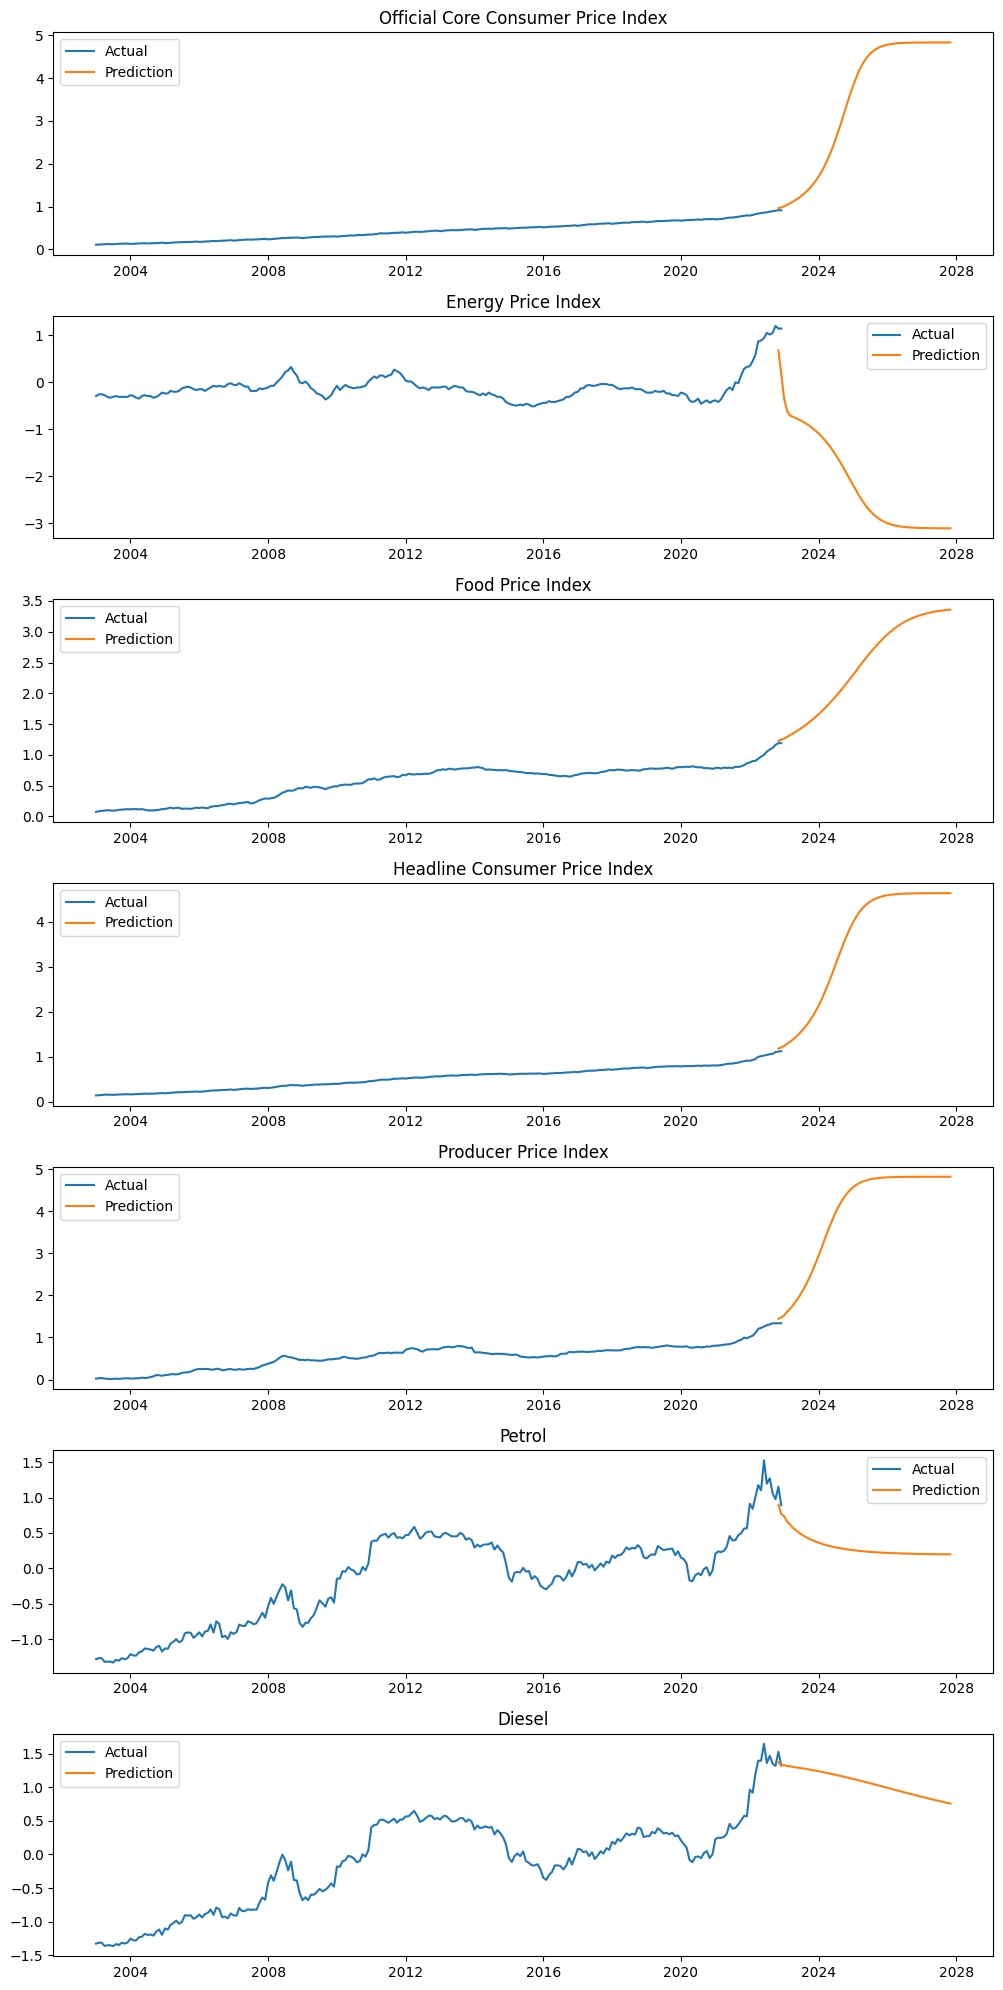

In [65]:
fig,axes = plt.subplots(7,1,figsize=(10,20),)

for i,col in enumerate(['Official Core Consumer Price Index','Energy Price Index','Food Price Index','Headline Consumer Price Index','Producer Price Index','Petrol','Diesel']):
    axes[i].plot(dataGreaterthan2003.index, dataGreaterthan2003[col], label='Actual')
    axes[i].plot(prediction_result.index, prediction_result[col], label='Prediction')
    axes[i].set_title(col)
    axes[i].legend()

fig.tight_layout()
plt.show()

## Multivariate Forecasting

### filtering principal components

In [66]:
principal_data = dataGreaterthan2003[['Producer Price Index', 'Energy Price Index', 'Official Core Consumer Price Index', 'Food Price Index','Petrol','Diesel']]

In [67]:
input_cols = ['Producer Price Index', 'Energy Price Index', 'Official Core Consumer Price Index', 'Food Price Index']
output_cols = ['Petrol','Diesel']
X = principal_data[input_cols].values
Y = principal_data[output_cols].values

### train and test split

In [68]:
X_train, Y_train = X[:num_rows-12, :], Y[:num_rows-12, :]
X_test, Y_test = X[num_rows-12:, :], Y[num_rows-12:, :]

### reshape input data

In [69]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

### model definition

In [70]:
# Define a function to create the model
def create_lstm_model_hyperparameter(learning_rate, epochs):
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(Y_train.shape[1]))
    optimizer = Adam(lr=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    model.fit(X_train, Y_train, epochs=epochs, batch_size=64, validation_data=(X_test, Y_test))
    test_loss  = model.evaluate(X_test, Y_test)
    return test_loss

### hyperparameter tuning

In [26]:
# Define a list of hyperparameters to tune

epochs = [50, 100, 150]
learning_rate = [0.001, 0.01, 0.1]

# Perform grid search for hyperparameter tuning
results = []

for lr in learning_rate:
    for epoch in epochs:
        loss = create_lstm_model_hyperparameter(lr, epoch)
        results.append({'learning_rate': lr,'epochs': epoch, 'loss': loss})

# Convert results to a DataFrame
results = pd.DataFrame(results)

Epoch 54/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0154 - val_loss: 0.1083
Epoch 55/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0145 - val_loss: 0.1036
Epoch 56/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0151 - val_loss: 0.0999
Epoch 57/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0154 - val_loss: 0.1235
Epoch 58/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0179 - val_loss: 0.1008
Epoch 59/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.1332
Epoch 60/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0164 - val_loss: 0.1185
Epoch 61/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0144 - val_loss: 0.1316
Epoch 62/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0140 - val_loss: 0.1249
Epoch 63/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0149 - val_loss: 0.1259
Epoch 64/100
4/4 

In [71]:
# results.to_csv('lstmMultivariateHyperParameters.csv')
results = pd.read_csv('lstmMultivariateHyperParameters.csv')

In [72]:
# find minimum value of 'loss' column
min_values = results['loss'].min()

# Filter original dataframe to only retain rows with minimum value for each group
result = results[results['loss'] == (min_values)]

result

,Unnamed: 0,learning_rate,epochs,loss
6,6,0.1,50,0.061776


### model implementation

In [73]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(32, activation='relu'))
model.add(Dense(Y_train.shape[1]))
optimizer = Adam(lr=result.iloc[0]['learning_rate'])
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(X_train, Y_train, epochs=int(result.iloc[0]['epochs']), batch_size=64, validation_data=(X_test, Y_test))

Epoch 1/50
/shared-libs/python3.9/py/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
4/4 [==============================] - 3s 426ms/step - loss: 1.7310 - val_loss: 1.1490
Epoch 2/50
4/4 [==============================] - 0s 16ms/step - loss: 0.4091 - val_loss: 0.9684
Epoch 3/50
4/4 [==============================] - 0s 13ms/step - loss: 0.1651 - val_loss: 0.1332
Epoch 4/50
4/4 [==============================] - 0s 9ms/step - loss: 0.0701 - val_loss: 0.2287
Epoch 5/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0589 - val_loss: 0.4529
Epoch 6/50
4/4 [==============================] - 0s 9ms/step - loss: 0.0506 - val_loss: 0.0337
Epoch 7/50
4/4 [==============================] - 0s 13ms/step - loss: 0.0457 - val_loss: 0.1271
Epoch 8/50
4/4 [==============================] - 0s 9ms/step - loss: 0.0393 - val_loss: 0.0465
Epoch 9/50
4/4 [===

In [74]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 429ms/step


### Loss curve

In [31]:
# model.save('lstmModel.h5')

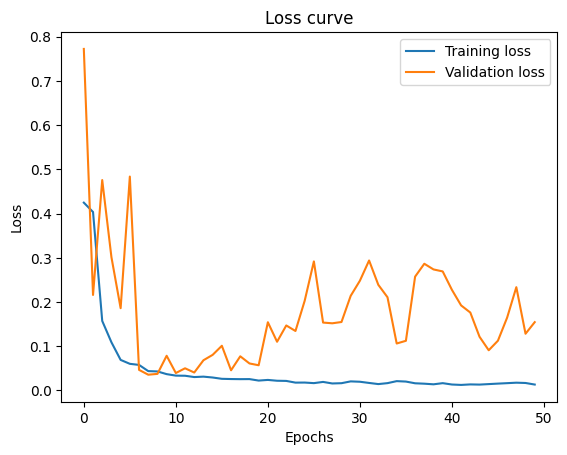

In [32]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluating model

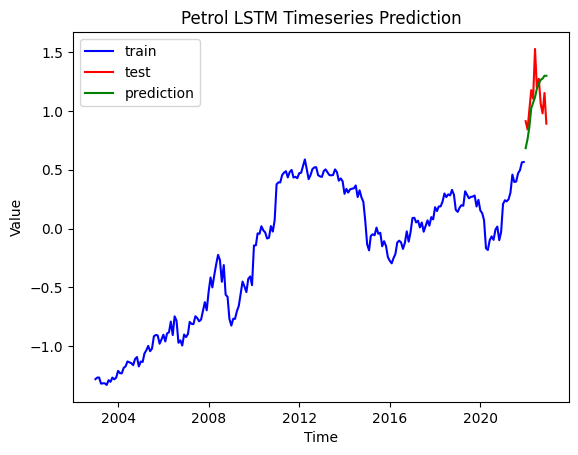

In [75]:
plt.plot(lstmTrainDF.index, Y_train[:, 0], color='blue', label='train')
plt.plot(lstmTestDF.index, Y_test[:, 0], color='red', label='test')
plt.plot(lstmTestDF.index, y_pred[:, 0], color='green', label='prediction')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Petrol LSTM Timeseries Prediction')
plt.legend()

plt.show()

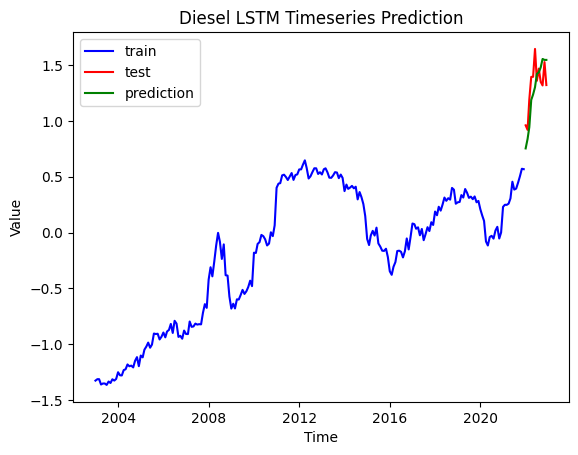

In [76]:
plt.plot(lstmTrainDF.index, Y_train[:, 1], color='blue', label='train')
plt.plot(lstmTestDF.index, Y_test[:, 1], color='red', label='test')
plt.plot(lstmTestDF.index, y_pred[:, 1], color='green', label='prediction')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Diesel LSTM Timeseries Prediction')
plt.legend()

plt.show()

### future prediction

In [77]:
X_test = prediction_result[input_cols].values
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [78]:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 7ms/step


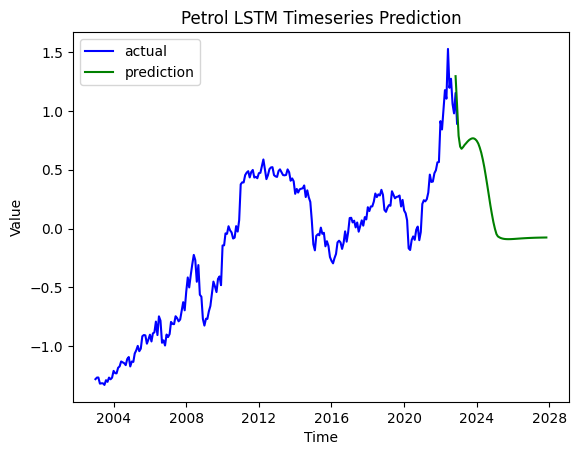

In [79]:
plt.plot(dataGreaterthan2003.index, dataGreaterthan2003['Petrol'], color='blue', label='actual')
plt.plot(prediction_result.index, y_pred[:, 0], color='green', label='prediction')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Petrol LSTM Timeseries Prediction')
plt.legend()

plt.show()

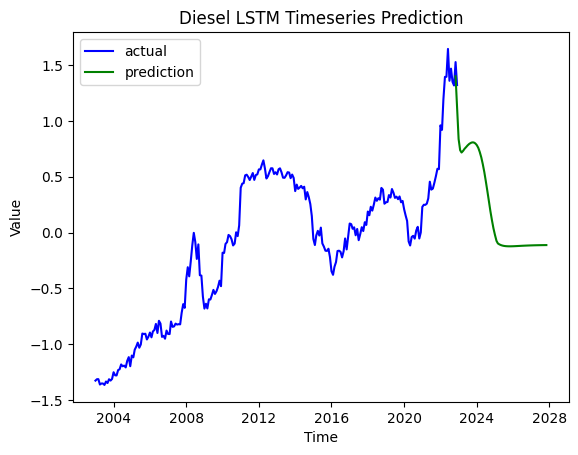

In [80]:
plt.plot(dataGreaterthan2003.index, dataGreaterthan2003['Diesel'], color='blue', label='actual')
plt.plot(prediction_result.index, y_pred[:, 1], color='green', label='prediction')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Diesel LSTM Timeseries Prediction')
plt.legend()

plt.show()

In [81]:
multi_prediction = pd.DataFrame(y_pred, index = prediction_result.index)
multi_prediction.columns = output_cols

In [82]:
multi_prediction.to_csv('multivariate_future_prediction_lstm.csv', index=True)

<AxesSubplot: >

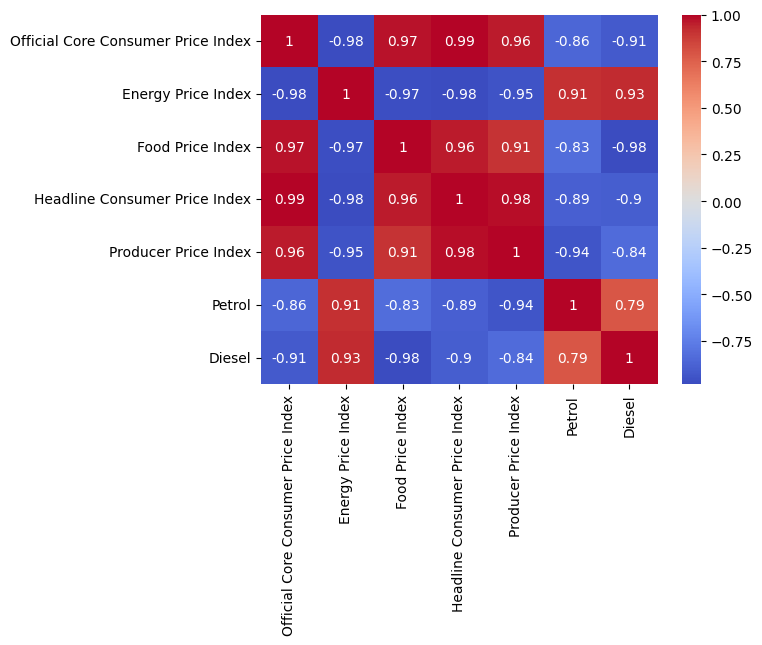

In [83]:
sns.heatmap(prediction_result.corr(), cmap='coolwarm', annot=True)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=638889fe-2546-41ac-8d2f-f9d8b29d307c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>